# Deloitte Quantum Challenge 2023

# =============================

# 0. References and credits

In [84]:
'''
Team: Quantux
Members: ...

V00 20230317 - Phase 1: Establishment
V01 20230226 - Phase 1: Add various local & realtime VQE client
V02 20230301 - Phase 1: Add decorators and modularise pipeline
'''

'\nTeam: Quantux\nMembers: ...\n\nV00 20230317 - Phase 1: Establishment\nV01 20230226 - Phase 1: Add various local & realtime VQE client\nV02 20230301 - Phase 1: Add decorators and modularise pipeline\n'

In [85]:
'''
References:
# Python functions
https://dev.to/kcdchennai/python-decorator-to-measure-execution-time-54hk

# Machine Learning modules
https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1

# Qiskit with latest post-migration modules and functions
https://github.com/PacktPublishing/Quantum-Chemistry-and-Computing-for-the-Curious/blob/main/Chapter_05_Variational_Quantum_Eigensolver_.VQE._algorithm_V2.ipynb

https://qiskit.org/documentation/nature/_modules/qiskit_nature/second_q/
https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html
https://qiskit.org/documentation/nature/tutorials/05_problem_transformers.html

# Qiskit realtime IBQM providers
https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.AccountProvider.html
https://qiskit.org/documentation/partners/qiskit_ibm_provider/tutorials/Migration_Guide_from_qiskit-ibmq-provider.html

'''

'\nReferences:\n# Python functions\nhttps://dev.to/kcdchennai/python-decorator-to-measure-execution-time-54hk\n\n# Machine Learning modules\nhttps://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1\n\n# Qiskit with latest post-migration modules and functions\nhttps://github.com/PacktPublishing/Quantum-Chemistry-and-Computing-for-the-Curious/blob/main/Chapter_05_Variational_Quantum_Eigensolver_.VQE._algorithm_V2.ipynb\n\nhttps://qiskit.org/documentation/nature/_modules/qiskit_nature/second_q/\nhttps://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html\nhttps://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html\nhttps://qiskit.org/documentation/nature/tutorials/05_problem_transformers.html\n\n# Qiskit realtime IBQM providers\nhttps://qiskit.org/documentation/stubs/qiskit.providers.ibmq.AccountProvider.html\nhttps://qiskit.org/documentation/partners/qiskit_ibm_provider/tutorials

# =============================

# 1. Import libraries and qiskit functions

In [86]:
# 0. Data science & ML libraries
# =============================
import pandas as pd
import numpy as np
import warnings, os, time
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings('ignore')

from functools import wraps
from qiskit.utils import algorithm_globals

from functools import partial
from scipy.optimize import minimize

_SEED = 5
np.random.seed(_SEED)
algorithm_globals.random_seed = _SEED

In [87]:
# All are post-migration imports, ie. qiskit_nature == 0.5.0
import qiskit, qiskit_nature
v_qiskit = qiskit.__version__
v_qiskit_nature = qiskit_nature.__version__

if (v_qiskit >= '0.22') and (v_qiskit_nature >= '0.5'):
    
    # 1. Load for runtime qiskit
    # =============================
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='deloitte-event23', group='level-1-access', project='quantux')
    # provider.backends() # List all backend providers
    qasm_simulator = provider.get_backend('ibmq_qasm_simulator')
    statevector_simulator = provider.get_backend('simulator_statevector')
    from qiskit.providers.aer import StatevectorSimulator
    from qiskit import Aer

    # 2. Molecule & backend definition
    # =============================
    from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
    from qiskit_nature.units import DistanceUnit
    from qiskit.utils import QuantumInstance
    from qiskit_nature.second_q.drivers import PySCFDriver

    # VQE Client seem can't be used, use VQE instead
    # from qiskit_nature.runtime import VQEClient

    # 3. Estimators & Sampler Primitives
    # =============================
    from qiskit.primitives import Estimator, Sampler

    # 4. Ansatz, initial circuit libraries, initial points (Ansatz parameters)
    # =============================
    from qiskit_nature.second_q.circuit.library import UCC, UCCSD, PUCCD, SUCCD, UVCCSD # Ansatz
    from qiskit_nature.second_q.circuit.library import HartreeFock # Initial State
    from qiskit.circuit.library import TwoLocal, PauliTwoDesign, EfficientSU2, RealAmplitudes # Initial Circuit
    from qiskit.quantum_info import Pauli
    #from qiskit.circuit.library.initial_states import hartree_fock, fermionic_gaussian_state, vscf
    #from qiskit.circuit.library.initial_points import mp2_initial_point, hf_initial_point, mp2_initial_point, vscf_initial_point

    # 5. Qubit Mappers & transformers
    # =============================
    from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, BravyiKitaevMapper, ParityMapper
    from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer

    # 6. Algorithms & optimizers
    # =============================
    from qiskit_nature.second_q.algorithms import NumPyMinimumEigensolverFactory, VQEUCCFactory, VQEUVCCFactory
    from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
    from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
    from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA, QNSPSA

    from qiskit.algorithms import HamiltonianPhaseEstimation, PhaseEstimation
    from qiskit.opflow import StateFn, PauliExpectation, CircuitSampler, PauliTrotterEvolution

else:
    print('Qiskit version not mostly updated - v2. Need updates before continue.')
    pass

ibmqfactory.load_account:WARNING:2023-03-07 09:27:02,207: Credentials are already in use. The existing account in the session will be replaced.


# =============================

# 2. Define construct problem modules

# 2-0. Decorators

In [88]:
# Timeit decorator
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__} took {total_time:.4f} seconds to run\n')
        return result
    return timeit_wrapper


In [89]:
# Try except decorator
def get_err_msg(value):
    def decorate(f):
        def applicator(_silent = False, *args, **kwargs):
            try:
                if not _silent:
                    print('{}: Loading...'.format(f.__name__))
                
                res = f(*args,**kwargs)
                
                if not _silent:
                    print('Success in loading {}'.format(f.__name__))
                return res
                
            except:
                if not _silent:
                    print('Fail in loading {}'.format(f.__name__))
                return value
        return applicator
    return decorate

# 2-1. Define modular functions

In [90]:
# 1. Get problem driver
#@get_err_msg('')
#@timeit
def _1_get_problem_driver(display_dict, input_value, basis = 'sto3g', input_type = 'molecule'):
    
    # =============================
    # 1. Define Molecule dictionary and return problem from PySCFDriver
    # =============================
    
    # =============================
    if input_type == 'molecule':
        moleculeinfo = MoleculeInfo(symbols = input_value['symbols'], coords = input_value['coords'], masses = input_value['masses'], 
                                    charge = input_value['charge'], multiplicity = input_value['multiplicity'])
    
    elif input_type == 'moleculeinfo':
        moleculeinfo = input_value
    
    driver = PySCFDriver.from_molecule(moleculeinfo, basis=basis)
    problem = driver.run()
    
    
    if display_dict is not None:
        display_dict['molecule'] = '{}'.format(input_value['symbols'])
        display_dict['charge'] = '{}'.format(input_value['charge'])
        display_dict['multiplicity'] = '{}'.format(input_value['multiplicity'])
        
        display_dict['reference_energy'] = '{}'.format(problem.reference_energy)
        display_dict['num_spin_orbitals'] = '{}'.format(problem.num_spin_orbitals)
        display_dict['num_spatial_orbitals'] = '{}'.format(problem.num_spatial_orbitals)
        display_dict['num_particles'] = '{}'.format(problem.num_particles)
        display_dict['nuclear_repulsion_energy'] = '{}'.format(problem.nuclear_repulsion_energy)
        display_dict['num_alpha'] = '{}'.format(problem.num_alpha)
        display_dict['num_beta'] = '{}'.format(problem.num_beta)
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
    
    return problem, display_dict_new

In [91]:
# 1. Get transform problem
#@get_err_msg('')
#@timeit
def _2_get_problem_transform(display_dict, problem, input_value, reduced):
    
    # =============================
    # 2. Transform the problem to reduce simulation space
    # =============================
    
    # =============================
    # If enter gas_molecules info, can transform; else if enter molecularinfo info, can not transform (should have previously transformed)
    
    # Problem reduction
    if reduced == 'FreezeCore':
        try:
            fc_transformer = FreezeCoreTransformer(freeze_core = input_value['fc_transformer']['fc_freeze_core'], 
                                                   remove_orbitals = input_value['fc_transformer']['fc_remove_orbitals'])
            problem = fc_transformer.transform(problem)
            display_chosen = input_value['fc_transformer']['fc_remove_orbitals']
        except:
            #print('FreezeCore Transformer did not succeed.')
            if display_dict is not None:
                display_dict['FreezeCoreTransformer'] = 'error'
            pass
        
        # How to determine which orbitals to be removed
        # https://quantumcomputing.stackexchange.com/questions/17852/use-one-body-integrals-to-know-which-orbitals-to-freeze-in-electronicstructurepr
        # https://www.youtube.com/watch?v=3B04KB0pDwE&t=667s
        
    elif reduced == 'ActiveSpace':
        #max_num_spatial_orbitals = problem.num_spatial_orbitals
        #max_num_electrons = problem.num_electrons
        #max_active_orbitals = itertools.combinations(max_num_spatial_orbitals, 2)
        # Use optuna to setup objective
        
        try:
            as_transformer = ActiveSpaceTransformer(num_electrons = input_value['as_transformer']['as_num_electrons'], 
                                                    num_spatial_orbitals = input_value['as_transformer']['as_num_spatial_orbitals'], 
                                                    active_orbitals = input_value['as_transformer']['as_active_orbitals'])
            problem = as_transformer.transform(problem)
            display_chosen = input_value['as_transformer']['as_active_orbitals']
        except:
            #print('ActiveSpace Transformer did not succeed.')
            if display_dict is not None:
                display_dict['ActiveSpaceTransformer'] = 'error'
            pass
    else:
        # print('Expect lengthy simulation if can not succeed in reducing orbitals using FreezeCoreTransformer or ActiveSpaceTransformer.')
        display_chosen = ''
        pass
    
    
    if display_dict is not None:
        display_dict['reduction_method'] = '{}'.format(reduced)
        display_dict['orbitals_removed'] = '{}'.format(display_chosen)
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
    
    return problem, display_dict_new

In [92]:
# 3. Get qubit operator
#@get_err_msg('')
#@timeit
def _3_get_qubit_operator(display_dict, problem, hyperparam, mapper_type):
    
    # =============================
    # 3. Define qubit mapping and convert to qubit operator
    # =============================
    
    # =============================
    # Qubit mapping
    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()
    
    fermionic_hamiltonian = problem.hamiltonian
    second_q_op = fermionic_hamiltonian.second_q_op()
    
    num_particles = problem.num_particles
        
    qubit_converter = QubitConverter(mapper, 
                                     two_qubit_reduction = hyperparam['two_qubit_reduction'], 
                                     z2symmetry_reduction = hyperparam['z2symmetry_reduction'])
    qubit_op = qubit_converter.convert(second_q_op, num_particles = num_particles, sector_locator = problem.symmetry_sector_locator)
    
    
    if display_dict is not None:
        display_dict['second_q_op'] = '{}'.format("\n".join(str(second_q_op).splitlines()[:10] + ["..."]))
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
        
    return qubit_op, qubit_converter, display_dict_new

In [93]:
# 4. Get quantum problem solver
#@get_err_msg('')
#@timeit
def _4_get_ansatz(display_dict, problem, hyperparam, qubit_converter, seed):
    
    # =============================
    # 4. Define various solver types with initalizing the ansatz or initial circuit
    # =============================
    
    # =============================
    num_spin_orbitals = problem.num_spin_orbitals
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    
    # i. List of ansatz
    #ansatz_lst = [UCCSD(), UCC(), PUCCD(), SUCCD(), UVCCSD()] # Others like PUCCD needs alpha == beta, ie. lots of restrictions thus all except UCCSD are left unused
    idx_ansatz = 0
    #ansatz_chosen = ansatz_lst[rand_ansatz]
    ansatz_uccsd = UCCSD()
    ansatz_hf = HartreeFock(num_spatial_orbitals, num_particles, qubit_converter)
    
    ansatz_lst = [ansatz_uccsd, ansatz_hf]
    ansatz_name = ['UCCSD', 'HartreeFock']
    idx_ansatz = np.random.randint(len(ansatz_lst))
    ansatz_chosen = ansatz_lst[idx_ansatz]
    
    # =============================
    # ii. For QNSPSA, must match num_qubits to the circuit observable, currently H2 is 4, use this constraint to subordinate for num_qubits' design from initial_circuits
    
    
    circuit_tl = TwoLocal(num_spin_orbitals, rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz', entanglement='full', reps=hyperparam['reps'], parameter_prefix = 'y')
    circuit_su2 = EfficientSU2(num_spin_orbitals, reps=hyperparam['reps'], entanglement="full")
    circuit_p2d = PauliTwoDesign(num_qubits=num_spin_orbitals, reps=hyperparam['reps'], seed=seed)
    circuit_ra = RealAmplitudes(num_qubits=num_spin_orbitals, reps=hyperparam['reps'])
    
    initial_circuit_lst = [circuit_tl, circuit_su2, circuit_p2d, circuit_ra]
    initial_circuit_name = ['TwoLocal', 'EfficientSU2', 'PauliTwoDesign', 'RealAmplitudes']
    idx_initial_circuit = np.random.randint(len(initial_circuit_lst))
    initial_circuit_chosen = initial_circuit_lst[idx_initial_circuit]
    
    # =============================
    # iii. Custom optimizers - A partial callable to scipy optimizer
    method_lst = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr']
    opt = [partial(minimize, method=i) for i in method_lst]

    optimizer_lst = [SPSA(maxiter=100), SLSQP(maxiter=100)] + opt
    optimizer_name = ['SPSA', 'SLSQP'] + ['minimize_{}'.format(i) for i in method_lst]
    idx_optimizer = np.random.randint(len(optimizer_lst))
    optimizer_chosen = optimizer_lst[idx_optimizer]
    
    if display_dict is not None:
        display_dict['ansatz_chosen'] = ansatz_name[idx_ansatz]
        display_dict['initial_circuit_chosen'] = initial_circuit_name[idx_initial_circuit]
        display_dict['optimizer_chosen'] = optimizer_name[idx_optimizer]
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
    
    return ansatz_chosen, initial_circuit_chosen, optimizer_chosen, display_dict_new

In [110]:
# 5. Get optimizer
#@get_err_msg('')
#@timeit
def _5_get_solver_optimizer(display_dict, problem, hyperparam, qubit_op, qubit_converter, solver_type, ansatz_chosen, initial_circuit_chosen, optimizer_chosen, method):
    
    # =============================
    # 5. Define VQE solvers to solve for PES in quantum chemistry
    # =============================
    
    # a. Solver and optimizer fixed set
    # =============================
    if solver_type == 'vqe_qnspsa':
        sampler = Sampler()
        ansatz = initial_circuit_chosen
        initial_point = np.random.random(ansatz.num_parameters)
        
        fidelity = QNSPSA.get_fidelity(ansatz, sampler)
        
        estimator = Estimator()
        # loss function
        def qnspsa_loss(x):
            result = estimator.run([ansatz], [qubit_op], [x]).result()
            return np.real(result.values[0])

        # QNSPSA solver directly tie to optimize function to directly call VPE, not using GSES or QPE
        solver = QNSPSA(fidelity, maxiter=300, learning_rate=1e-2, perturbation=0.7)
        ground_state = solver.optimize(ansatz.num_parameters, qnspsa_loss, initial_point=initial_point)
        energy = ground_state[1]
        
    # =============================
    elif solver_type == 'vqe_runtime':
        ansatz = initial_circuit_chosen
        optimizer = optimizer_chosen
        backend = hyperparam['backend']
        #solver = VQE(ansatz, optimizer, quantum_instance=backend, shots=1024, measurement_error_mitigation=True)
        estimator = Estimator()
        solver = VQE(estimator, ansatz, optimizer)
        
        ground_state = solver.compute_minimum_eigenvalue(qubit_op)
        energy = ground_state.eigenvalue # ground_state.total_energies[0].real
        
    # =============================
    elif solver_type == 'vqe_runtime_with_noise':
        pass
    
    # b. Customizable Solvers and optimizers
    # =============================
    # Solvers
    elif solver_type == 'numpy_solver_with_filter':
        solver = NumPyMinimumEigensolverFactory(use_default_filter_criterion=True)
    # =============================
    elif solver_type == 'numpy_solver':
        solver = NumPyMinimumEigensolverFactory()
    # =============================
    elif solver_type == 'vqe_ansatz':
        estimator = Estimator()
        ansatz = ansatz_chosen
        optimizer = optimizer_chosen
        
        solver = VQEUCCFactory(estimator, ansatz, optimizer)
    # =============================
    elif solver_type == 'vqe_initial_circuit':
        estimator = Estimator()
        initial_circuit = initial_circuit_chosen
        optimizer = optimizer_chosen
        
        solver = VQE(estimator, initial_circuit, optimizer)
    
    # =============================
    # Optimizers
    if method == 'gses':
        calc = GroundStateEigensolver(qubit_converter, solver)
        ground_state = calc.solve(problem)
            
        energy = ground_state.total_energies[0].real

    elif method == 'qpe':
        # Quantum Phase Estimation
        quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))
        evolution = PauliTrotterEvolution('trotter', reps = hyperparam['qpe_num_time_slices'])

        qpe = HamiltonianPhaseEstimation(hyperparam['qpe_n_ancilliae'], quantum_instance=quantum_instance)

        state_preparation = None
        # state_preparation = 
        ground_state = qpe.estimate(qubit_op, state_preparation, evolution=evolution)

        energy = ground_state.most_likely_eigenvalue

    
    if display_dict is not None:
        display_dict['solver'] = '{}'.format(solver_type)
        display_dict['solution_method'] = '{}'.format(method)
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
        
    return ground_state, energy, display_dict_new


# 2-2. Build construct pipeline

In [95]:
# Create construct problem
#@get_err_msg('')
#@timeit
def get_construct_problem(input_value, hyperparam, input_type, display_report, reduced, basis, mapper_type, solver_type, method, seed):
    
    # =============================
    # 0. Display Report Dict
    # =============================
    if display_report == True:
        display_dict = {}
    else:
        display_dict = None
    
    # =============================
    # A. The quantum solver pipeline
    # =============================
    
    # Specify input_type = 'molecule' or 'moleculeinfo'
    problem, display_dict_1 = _1_get_problem_driver(display_dict, input_value, basis = basis, input_type = input_type)
    
    problem, display_dict_2 = _2_get_problem_transform(display_dict_1, problem, input_value, reduced)
    
    qubit_op, qubit_converter, display_dict_3 = _3_get_qubit_operator(display_dict_2, problem, hyperparam, mapper_type)
    
    ansatz_chosen, initial_circuit_chosen, optimizer_chosen, display_dict_4 = _4_get_ansatz(display_dict, problem, hyperparam, qubit_converter, seed)
    
    ground_state, energy, display_dict_5 = _5_get_solver_optimizer(display_dict_4, problem, hyperparam, 
                                                                   qubit_op, qubit_converter, solver_type, ansatz_chosen, initial_circuit_chosen, optimizer_chosen, method)
    
    if display_report == True:
        display_df = pd.DataFrame.from_dict([display_dict_5])
    else:
        display_df = None
    
    return ground_state, energy, display_df


In [96]:
# ===
gas_molecules = {
    'h2': {'symbols': ["H", "H"],
           'coords': [(0.0000, 0.0000, 0.0000),
                      (0.0000, 0.0000, 0.7414)],
           'multiplicity': 1,
           'charge': 0,
           'units': DistanceUnit.ANGSTROM,
           'masses': [1, 1],
           # 'atom_pair': (1, 2), # not available after migration
           'fc_transformer': {
               'fc_freeze_core': True, 
               'fc_remove_orbitals': None,
               },
           'as_transformer': {
               'as_num_electrons': 0,
               'as_num_spatial_orbitals': 2,
               'as_active_orbitals': [1, 1],
               }
           }
}

hyperparameters = {
    'h2': {'reps': 2,
           'two_qubit_reduction': True,
           'z2symmetry_reduction': 'auto',
           'perturbation_steps': np.linspace(0.5, 4.0, 250),
           'qpe_num_time_slices': 1,
           'qpe_n_ancilliae': 3,
           'atom_pair': (1, 2), # index start from 1
          },

}

solution_master = {
    'classical': ['numpy_solver', 'numpy_solver_with_filter'],
    'quantum': ['vqe_qnspsa', 'vqe_runtime', 'vqe_runtime_with_noise', 'vqe_ansatz', 'vqe_ansatz', 'vqe_initial_circuit']
}

# ===
molecule = gas_molecules['h2']
hyperparam = hyperparameters['h2']
# display_report = False
display_dict = {}
reduced = 'FreezeCore'
basis = 'sto3g'
mapper_type = 'JordanWignerMapper'
solver_type = 'numpy_solver'
method = 'gses'


# ======================================

# 3-1. Calculate molecule energy by BOPES calculations

In [97]:
def get_molecule_perturbation_list(moleculeinfo, hyperparam, perturbation_steps):
    
    from copy import deepcopy
    
    EPSILON = 1e-3
    
    atom_pair = hyperparam['atom_pair']
    pair_0, pair_1 = atom_pair
    
    x0, y0, z0 = moleculeinfo.coords[pair_0 - 1]
    x1, y1, z1 = moleculeinfo.coords[pair_1 - 1]
    
    # Get a straight line connecting the 2 interacting atom pair, y = mx + p
    m = 0
    p = y0
    if abs(x1 - x0) > EPSILON:
        m = (y1 - y0)/(x1 - x0)
        p = y0 - m*x0
    
    # This perturbation assumes lying on the same plane
    size = len(perturbation_steps)
    energy_lst = np.empty(size)
    
    perturbation_lst = []
    for k in range(size):
        # print("Step: ", k)
        
        if (abs(x0) < EPSILON and abs(y0) < EPSILON):
            z0_new = z0 + perturbation_steps[k]
            
            coords_new = []
            for l in range(len(moleculeinfo.coords)):
                if l == atom_pair[0]:
                    coords_new.append((0.0, 0.0, z0_new))
                else:
                    coords_new.append(moleculeinfo.coords[l])
        
        elif (abs(z0) < EPSILON and abs(z1) < EPSILON):
            x0_new = x0 + perturbation_steps[k]
            y0_new = m*x0_new + p
            
            coords_new = []
            for l in range(len(moleculeinfo.coords)):
                if l == atom_pair[0]:
                    coords_new.append((x0_new, y0_new, 0.0))
                else:
                    coords_new.append(moleculeinfo.coords[l])
                    
        else:
            print("bopes - Error: unsupported molecule geometry, atom pairs must be in the same line or in the same plane")
            return perturbation_steps, 0
    
        moleculeinfo_new = deepcopy(moleculeinfo)
        moleculeinfo_new.coords = coords_new
        
        perturbation_lst.append(moleculeinfo_new)
        
    return perturbation_lst

In [98]:
# Get BOPES energy curve

def get_molecule_bopes(input_value, hyperparam, input_type = 'molecule',
                       reduced = 'ActiveSpace', basis = 'sto3g', mapper_type = 'JordanWignerMapper', solver_type = 'numpy_solver', method = 'gses', 
                       perturbation_steps = np.linspace(0.5, 3, 250), display_report = False, seed = _SEED):
    
    # Obtain molecule coordinates
    # ===========================
    EPSILON = 1e-3
    
    if input_type == 'molecule':
        moleculeinfo = MoleculeInfo(symbols = input_value['symbols'], coords = input_value['coords'], masses = input_value['masses'], 
                                    charge = input_value['charge'], multiplicity = input_value['multiplicity'])
    
    elif input_type == 'moleculeinfo':
        moleculeinfo = input_value
    
    perturbation_lst = get_molecule_perturbation_list(moleculeinfo, hyperparam, perturbation_steps)
    
    energy_lst = []
    for k in tqdm(range(len(perturbation_lst)), position = 0, leave = True):
        
        tmp_moleculeinfo = perturbation_lst[k]
        
        # Get ground state energy from construct problem
        # ===========================
        _, tmp_energy, _ = get_construct_problem(input_value = tmp_moleculeinfo, hyperparam = hyperparam, input_type = 'moleculeinfo', display_report = False, 
                                             reduced = reduced, basis = basis, mapper_type = mapper_type, solver_type = solver_type, method = method, seed = seed)
        energy_lst.append(tmp_energy)
        
    if display_report:
        from matplotlib import pyplot as plt
        %matplotlib inline
        plt.rcParams["figure.figsize"] = [10, 10]
        plt.rcParams["figure.autolayout"] = True
        
        df = pd.DataFrame(list(zip(energy_lst, perturbation_steps)), columns = ['step', 'energy'])
        fig, ax = plt.subplots(facecolor='lightslategray')
        ax.set_clip_on(False)
        df.plot(kind='scatter', x='energy', y='step', ax=ax, color='black', linewidth=0, label = 'VQE Energy (HF)')
        
        e_min = min(energy_lst)
        p_min = perturbation_steps[energy_lst == e_min]
        print('Molecule energy:{} with atoms separated at {} apart'.format(e_min, p_min))
        
    return perturbation_steps, energy_lst


# Load Quantistry coordinates for comparison

In [99]:
import pandas as pd
import numpy as np
from zipfile import *
import warnings, os, gzip
warnings.filterwarnings('ignore')
pth = os.getcwd() + r'/quantistry'

def get_coord(zip_file):
    all_res = []

    with ZipFile(zip_file, 'r') as f:
        coord_list = [x for x in f.namelist() if 'csv' not in x]
        for i in coord_list:
            tmp = f.extract(i)
            df = pd.read_csv(tmp)

            new_df = []
            for j in range(len(df)):
                df.iloc[j] = df.iloc[j].str.replace('  ', ' ', regex = True)
                new_df.append(df.iloc[j].str.split(' ', expand = True))

            new_df = pd.concat(new_df)
            
            new_df0 = pd.DataFrame(['{}'.format(i).replace('.xyz', '')] * len(new_df), columns = ['step'])
            
            new_df1 = new_df.iloc[:, 0].reset_index(drop = True)
            
            new_df2 = new_df.iloc[:, 1:]
            out = pd.DataFrame(new_df2.iloc[:,::-1].apply(lambda x: x.dropna().tolist(), axis=1).tolist(), columns=new_df2.columns[::-1]).iloc[:,::-1]
            out.replace('', float('NaN'), inplace = True)
            out.dropna(axis = 1, how = 'all', inplace = True)

            final = pd.concat([new_df0, new_df1, out], axis = 1)
            final.columns = ['step', 'atom', 'x', 'y', 'z']
            all_res.append(final)

        f.close()
        
    return pd.concat(all_res)


In [100]:
def getCoordinate(data, step, size):
    mol_start = step*size
    mol = data.get("atom").values[mol_start:mol_start + size]
    #print(data, dir(mol), mol)
    coords = []
    for size_start in range(mol_start,mol_start + size):
        coordx = float(data.get("x")[size_start:size_start+1].values[:1].real[0])
        coordy = float(data.get("y")[size_start:size_start+1].values[:1].real[0])
        coordz = float(data.get("z")[size_start:size_start+1].values[:1].real[0])

        coords.append([coordx,coordy,coordz])
    return mol, coords

# 4. Deployment

In [121]:
# ===
exact_energies = []
vqe_energies = []

steps = range(0,2)
for step in steps:
    Co2_CO2 = get_coord(pth + r'/Co2_CO2.zip')
    mol, coords = getCoordinate(Co2_CO2, step, 4)
    print(mol, coords)

    gas_molecules = {
        'CoCO2': {'symbols': mol,
               'coords': coords,
               'multiplicity': 1,
               'charge': 1,
               'units': DistanceUnit.ANGSTROM,
               'masses': [59, 16, 12, 16],
               #'atom_pair': (1, 2), # not available after migration
               'fc_transformer': {
                   'fc_freeze_core': True, 
                   'fc_remove_orbitals': range(13,30),
                   },
    #           'as_transformer': {
    #               'as_num_electrons': 0,
    #               'as_num_spatial_orbitals': 2,
    #               'as_active_orbitals': [1, 1],
    #               }
               }
    }

    hyperparameters = {
        'CoCO2': {'reps': 2,
               'two_qubit_reduction': True,
               'z2symmetry_reduction': 'auto',
               'provider': provider,
               'backend': qasm_simulator
              },

    }


    # ===
    molecule = gas_molecules['CoCO2']
    hyperparam = hyperparameters['CoCO2']
    # display_report = False
    display_dict = {}

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['CoCO2'], hyperparam = hyperparameters['CoCO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'numpy_solver', method = 'gses', seed = _SEED)
    print("Classical:", _, energy, display_df )
    exact_energies.append(energy)

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['CoCO2'], hyperparam = hyperparameters['CoCO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'vqe_runtime', method = 'gses', seed = _SEED)
    print("Quantum mechanic:", _, energy, display_df )
    vqe_energies.append(energy)


['Co' 'O' 'C' 'O'] [[6.844708500129254, 5.772690500054138, 5.0], [8.228239500226193, 6.352208500094744, 5.0], [9.29272350030078, 6.822059500127666, 5.0], [10.323201500372985, 7.276646500159519, 5.0]]
Classical: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1748.798056791184
  - computed part:      -4.201467352547
  - FreezeCoreTransformer extracted energy part: -1744.596589438637
~ Nuclear repulsion energy (Hartree): 197.72157981526
> Total ground state energy (Hartree): -1551.076476975925
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [735.05621649  577.92708037  462.98290052]
 
  0: 
  * Electronic dipole moment (a.u.): [719.02273518  565.72516174  453.5342699]
    - computed part:      [34.26644858  25.40941364  18.89726125]
    - FreezeCoreTransformer extracted energy part: [684.7562866  540.31574811  434.63700865]
  > Dipole moment (a.u.): [16.03348131  1

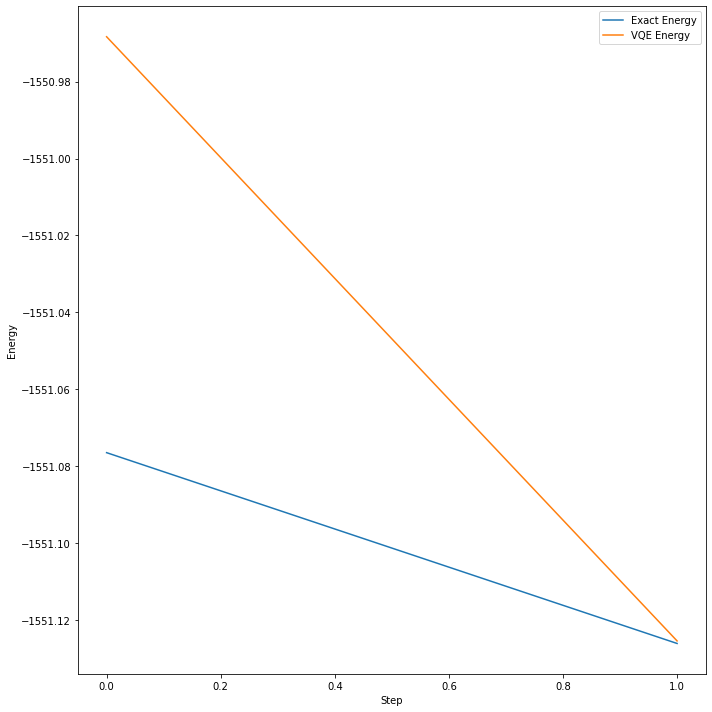

In [122]:

plt.plot(steps, exact_energies, label="Exact Energy")
plt.plot(steps, vqe_energies, label="VQE Energy")
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()


In [123]:
print(exact_energies,vqe_energies)

[-1551.0764769759248, -1551.1260854895988] [-1550.9683389856202, -1551.125424631311]


In [32]:
# ===
gas_molecules = {
    'h2': {'symbols': ["H", "H"],
           'coords': [(0.0000, 0.0000, 0.0000),
                      (0.0000, 0.0000, 0.7414)],
           'multiplicity': 1,
           'charge': 0,
           'units': DistanceUnit.ANGSTROM,
           'masses': [1, 1],
           # 'atom_pair': (1, 2), # not available after migration
           'fc_transformer': {
               'fc_freeze_core': True, 
               'fc_remove_orbitals': None,
               },
           'as_transformer': {
               'as_num_electrons': 0,
               'as_num_spatial_orbitals': 2,
               'as_active_orbitals': [1, 1],
               }
           }
}

hyperparameters = {
    'h2': {'reps': 2,
           'two_qubit_reduction': True,
           'z2symmetry_reduction': 'auto',
           'perturbation_steps': np.linspace(0.5, 4.0, 250),
           'qpe_num_time_slices': 1,
           'qpe_n_ancilliae': 3,
           'atom_pair': (1, 2), # index start from 1
          },

}

solution_master = {
    'classical': ['numpy_solver', 'numpy_solver_with_filter'],
    'quantum': ['vqe_qnspsa', 'vqe_runtime', 'vqe_runtime_with_noise', 'vqe_ansatz', 'vqe_ansatz', 'vqe_initial_circuit']
}

# ===
molecule = gas_molecules['h2']
hyperparam = hyperparameters['h2']
# display_report = False
display_dict = {}
reduced = 'FreezeCore'
basis = 'sto3g'
mapper_type = 'JordanWignerMapper'
solver_type = 'numpy_solver'
method = 'gses'


In [33]:
_, energy, display_df = get_construct_problem(input_value = gas_molecules['h2'], hyperparam = hyperparameters['h2'], input_type = 'molecule', display_report = False, reduced = 'ActiveSpace', basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                          solver_type = 'numpy_solver', method = 'gses', seed = _SEED)

100%|██████████| 250/250 [1:15:54<00:00, 18.22s/it]    


Molecule energy:-1.1372927050670416 with atoms separated at [0.73092369] apart


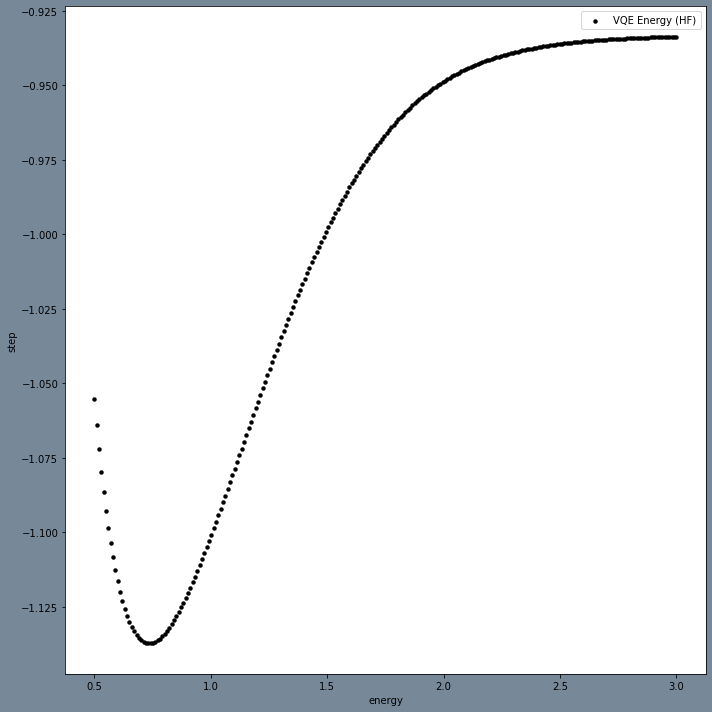

In [37]:
perturb_steps, energy_lst = get_molecule_bopes(input_value = gas_molecules['h2'], hyperparam = hyperparameters['h2'], input_type = 'molecule',
                                               reduced = 'FreezeCore', basis = 'sto3g', mapper_type = 'JordanWignerMapper', solver_type = 'numpy_solver', method = 'gses', 
                                               perturbation_steps = np.linspace(0.5, 3.0, 250), display_report = True, seed = _SEED)

In [ ]:
gas_molecules = {
    'h2': {'symbols': ["H", "H"],
           'coords': [(0.0000, 0.0000, 0.0000),
                      (0.0000, 0.0000, 0.7414)],
           'multiplicity': 1,
           'charge': 0,
           'units': DistanceUnit.ANGSTROM,
           'masses': [1, 1],
           'atom_pair': (1, 2),
           'fc_transformer': {
               'fc_freeze_core': True, 
               'fc_remove_orbitals': None,
               },
           'as_transformer': {
               'as_num_electrons': 0,
               'as_num_spatial_orbitals': 2,
               'as_active_orbitals': [1, 1],
               }
           },
    'n2': {'symbols': ["N", "N"],
           'coords': [(0.0000, 0.0000, 0.5488), 
                      (0.0000, 0.0000, -0.5488)],
           'multiplicity': 4,
           'charge': 0,
           'units': DistanceUnit.ANGSTROM,
           'masses': [7, 7],
           'atom_pair': (1, 2),
           'fc_transformer': {
               'fc_freeze_core': True, 
               'fc_remove_orbitals': None,
               },
           'as_transformer': {
               'as_num_electrons': 0,
               'as_num_spatial_orbitals': 2,
               'as_active_orbitals': [1, 1],
               }
           
           
           },
    'co2': {'symbols': ["C", "O", "O"],
            'coords': [(0.0000, 0.0000, 0.0000),
                       (0.0000, 0.0000, 1.1621),
                       (0.0000, 0.0000, -1.1621)],
            'multiplicity': 2,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'h2o': {'symbols': ["O", "H", "H"],
            'coords': [(0.0000, 0.0000, 0.1173),
                       (0.0000, 0.7572, -0.4692),
                       (0.0000, -0.7572, -0.4692)],
            'multiplicity': 1,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'so2': {'symbols': ["S", "O", "O"],
            'coords': [(0.0000, 0.0000, 0.0000),
                       (0.0000, 1.2371, 0.7215),
                       (0.0000, -1.2371, 0.7215)],
            'multiplicity': 1,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'no2': {'symbols': ["N", "O", "O"],
            'coords': [(0.0000, 0.0000, 0.0000),
                       (0.0000, 1.0989, 0.4653),
                       (0.0000, -1.0989, 0.4653)],
            'multiplicity': 2,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'n2o': {'symbols': ["N", "N", "O"],
            'coords': [(0.0000, 0.0000, -1.1998),
                       (0.0000, 0.7572, -0.0716),
                       (0.0000, -0.7572, 1.126)],
            'multiplicity': 1,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'ch4': {'symbols': ["C", "H", "H", "H", "H"],
            'coords': [(0.0000, 0.0000, 0.0000), 
                       (0.6276, 0.6276, 0.6276),
                       (0.6276, -0.6276, -0.6276),
                       (-0.6276, 0.6276, -0.6276),
                       (0.6276, -0.6276, 0.6276)],
            'multiplicity': 1,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 1, 1, 1, 1],
            'atom_pair': (1, 4)
           },
    

}

# Not updated
# Spin multiplicity check SO2, N2O, CH4
